In [11]:
import warnings

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from minio import Minio
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

mpl.style.use("fivethirtyeight")
mpl.rcParams["figure.figsize"] = (15, 8)
mpl.rcParams["figure.dpi"] = 50
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25


In [2]:
# --------------------------------------------------------------
# Connecting to Data Lake
# --------------------------------------------------------------

client = Minio(
    "localhost:9000", access_key="minioadmin", secret_key="minioadmin", secure=False
)

In [4]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle("../data/interim/01_cleaned_data.pkl")

df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   department           14999 non-null  object 
 1   salary               14999 non-null  object 
 2   averageMonthlyHours  14999 non-null  int32  
 3   projectCount         14999 non-null  int32  
 4   satisfaction         14999 non-null  float64
 5   evaluation           14999 non-null  float64
 6   yearsAtCompany       14999 non-null  int32  
 7   workAccident         14999 non-null  int32  
 8   turnover             14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 878.8+ KB


In [6]:
# --------------------------------------------------------------
# Converting the categorical attributes to numerical values
# --------------------------------------------------------------

# Note: We have no high cardinality (few different values)

# This code is converting categorical variables "department" and "salary"
# into numerical codes using the .astype("category").cat.codes method.
# It assigns a unique numerical code to each category within these columns.

df["department"] = df["department"].astype("category").cat.codes
df["salary"] = df["salary"].astype("category").cat.codes

df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,7,1,266,2,38.0,53.0,3,0,1
1,7,2,252,5,80.0,86.0,6,0,1
2,7,2,289,7,11.0,88.0,4,0,1
3,7,1,275,5,72.0,87.0,5,0,1
4,7,1,292,2,37.0,52.0,3,0,1


In [7]:
# --------------------------------------------------------------
# Splitting the data into X and y
# --------------------------------------------------------------

target_name = "turnover"
X = df.drop("turnover", axis=1)
y = df[target_name]


In [8]:
# --------------------------------------------------------------
# Transforming dataset
# --------------------------------------------------------------

# Normalizing the range of features so that they all have a consistent scale
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [9]:
# --------------------------------------------------------------
# Splitting the data into train and test
# --------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)


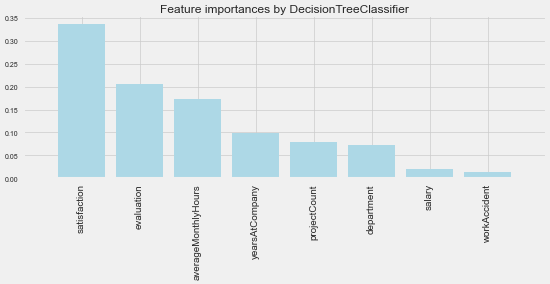

In [12]:
# --------------------------------------------------------------
# Using Decision Tree model
# --------------------------------------------------------------

# Fitting the model to the training data
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

# Importances of the features
importances = dtree.feature_importances_
feat_names = df.drop(["turnover"], axis=1).columns

# Plotting the importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color="lightblue", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation="vertical", fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [13]:
# --------------------------------------------------------------
# Filtering only the relevant attributes.
# --------------------------------------------------------------

# Selected features
X = df[["satisfaction", "evaluation", "averageMonthlyHours", "yearsAtCompany"]]

# Scalling the selected features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

X

array([[0.31868132, 0.265625  , 0.38202247, 0.125     ],
       [0.78021978, 0.78125   , 0.2247191 , 0.5       ],
       [0.02197802, 0.8125    , 0.64044944, 0.25      ],
       ...,
       [0.30769231, 0.265625  , 0.62921348, 0.125     ],
       [0.02197802, 0.9375    , 0.4494382 , 0.25      ],
       [0.30769231, 0.25      , 0.49438202, 0.125     ]])

In [14]:
# --------------------------------------------------------------
# Base Line model
# --------------------------------------------------------------

# This function defines a simple baseline model called base_rate_model.
# The purpose of this model is to serve as a basic reference point for
# comparison with other models. It predicts a target value of 0 for each
# input sample in X, regardless of the features in the data.

# We estimate that the employee does not have turnover, as we have a 75% chance
# of being correct. Therefore, it makes sense for the baseline model to always return 0.
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

In [15]:

# --------------------------------------------------------------
# Model evaluation metrics
# --------------------------------------------------------------
def accuracy_result(y_test, y_predict):
    # Calculate the accuracy score by comparing predicted values (y_predict) with
    # actual values (y_test).
    acc = accuracy_score(y_test, y_predict)
    # Print the accuracy score with a format of two decimal places.
    print("Accuracy = %2.2f" % acc)


def roc_classification_report_results(model, y_test, y_predict):
    # Calculate the ROC AUC score by comparing predicted values (y_predict) with
    # actual values (y_test).
    roc_ = roc_auc_score(y_test, y_predict)
    # Generate a classification report to evaluate model performance.
    classification_report_str = classification_report(y_test, y_predict)

    # Print the model name, ROC AUC score, and the classification report.
    print("\n{} ROC AUC = {}\n".format(model, roc_))
    print(classification_report_str)

#### ROC Curve
---

When dealing with imbalanced classes as the target variable, using the Receiver Operating Characteristic (ROC) curve is often preferred over accuracy. Here's why:

1. **Sensitivity to Imbalance:** Accuracy can be misleading in imbalanced datasets, as it can be high even when the model predicts the majority class well but performs poorly on the minority class. In such cases, accuracy might not reflect the true performance.

2. **Class Distribution:** ROC curve considers the True Positive Rate (TPR) and False Positive Rate (FPR) across different probability thresholds. It helps in visualizing how well the model can discriminate between the positive and negative classes, irrespective of their imbalance.

3. **Threshold Selection:** In imbalanced scenarios, you might need to adjust the classification threshold to balance precision and recall. ROC curves provide insights into how different threshold values impact the model's performance.

4. **AUC Score:** The Area Under the ROC Curve (AUC) summarizes the model's performance across various thresholds. A higher AUC suggests better overall performance in distinguishing between the classes.

5. **Focus on True Positive Rate:** ROC curve emphasizes the True Positive Rate, which is important when the cost of missing positive cases (False Negatives) is high, like in medical diagnosis or fraud detection.

In summary, the ROC curve provides a more comprehensive view of a model's performance, especially when dealing with imbalanced classes. It considers the trade-offs between sensitivity and specificity, which are crucial in scenarios where the costs of misclassification are asymmetric.



In [16]:
def plot_roc_curve(y_test, y_predict):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a binary classification model.

    Parameters:
    y_test (array-like): True binary labels.
    y_predict (array-like): Predicted probabilities of the positive class.
    """
    fpr, tpr, _ = roc_curve(
        y_test, y_predict
    )  # Calculate the ROC curve values (false positive rate and true positive rate)
    roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve (AUC) for ROC

    # Create a new figure
    plt.figure()
    # Plot the ROC curve using dark orange color and label it with AUC value
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.4f)" % roc_auc
    )
    # Plot the diagonal dashed line representing random guessing
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # Set the x and y axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # Set x and y axis labels and title
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    # Add a legend in the lower right corner
    plt.legend(loc="lower right")
    # Display the plot
    plt.show()


Accuracy = 0.76

Base Model ROC AUC = 0.5

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2286
           1       0.00      0.00      0.00       714

    accuracy                           0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



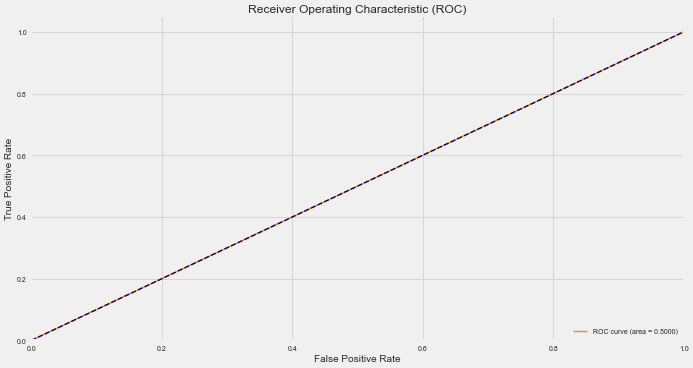

In [17]:
# --------------------------------------------------------------
# Analyzing the performance of the baseline model
# --------------------------------------------------------------

# Generate predictions using the base rate model for the test data
y_predict = base_rate_model(X_test)

# Calculate and display the accuracy of the predictions
accuracy_result(y_test, y_predict)

# Calculate and display the ROC AUC and classification report for the base model
roc_classification_report_results("Base Model", y_test, y_predict)

# Plot the ROC curve for the base model using the predicted probabilities
plot_roc_curve(y_test, y_predict)


Accuracy = 0.76

Logistic Regression ROC AUC = 0.5333579626076153

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      2286
           1       0.52      0.09      0.16       714

    accuracy                           0.76      3000
   macro avg       0.65      0.53      0.51      3000
weighted avg       0.71      0.76      0.70      3000



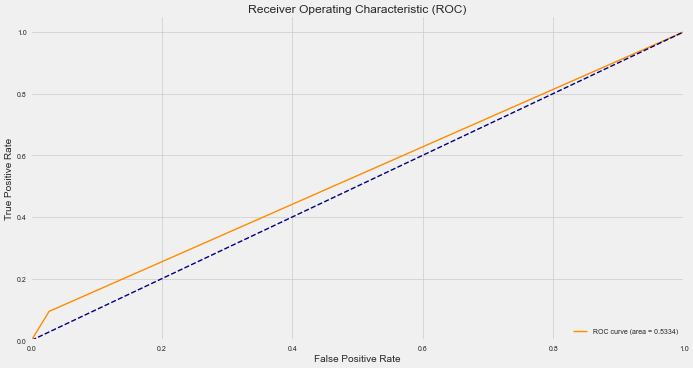

In [18]:
# --------------------------------------------------------------
# Logistics Regression Model
# --------------------------------------------------------------

# Initialize a LogisticRegression model.
lreg = LogisticRegression()

# Fit the model to the training data.
lreg.fit(X_train, y_train)

# Use the trained model to make predictions on the test data.
y_predict = lreg.predict(X_test)

# Calculate and print the accuracy of the predictions using the accuracy_result function.
accuracy_result(y_test, y_predict)

# Generate and print the ROC AUC score and classification report using roc_classification_report_results function.
roc_classification_report_results("Logistic Regression", y_test, y_predict)

# Call the function to plot the ROC curve
plot_roc_curve(y_test, y_predict)

Accuracy = 0.74

Decision Tree ROC AUC = 0.6578295360138806

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2286
           1       0.46      0.50      0.48       714

    accuracy                           0.74      3000
   macro avg       0.65      0.66      0.65      3000
weighted avg       0.75      0.74      0.75      3000



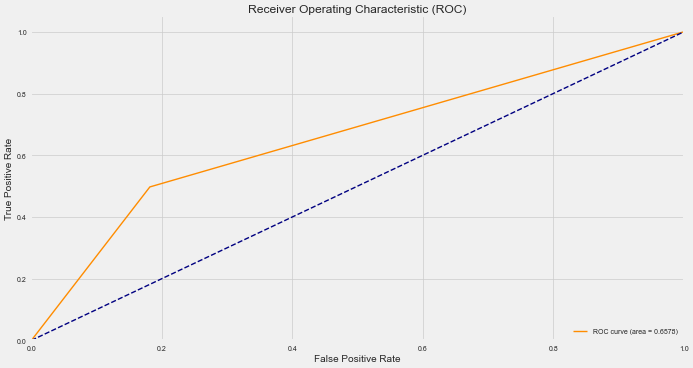

In [19]:
# --------------------------------------------------------------
# Decision Tree Model
# --------------------------------------------------------------

# Initialize and train a Decision Tree Classifier
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

# Generate predictions using the trained Decision Tree model for the test data
y_predict = dt.predict(X_test)

# Calculate and display the accuracy of the predictions
accuracy_result(y_test, y_predict)

# Calculate and display the ROC AUC and classification report for the Decision Tree model
roc_classification_report_results("Decision Tree", y_test, y_predict)

# Plot the ROC curve for the Decision Tree model using the predicted probabilities
plot_roc_curve(y_test, y_predict)

Accuracy = 0.83

Random Forest ROC AUC = 0.720871288147805

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2286
           1       0.68      0.52      0.59       714

    accuracy                           0.83      3000
   macro avg       0.77      0.72      0.74      3000
weighted avg       0.82      0.83      0.82      3000



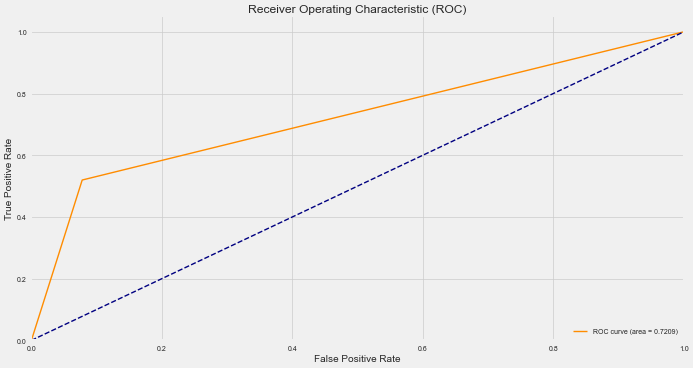

In [22]:
# --------------------------------------------------------------
# Random Tree Model (Random Forest)
# --------------------------------------------------------------

# Initialize and train a Random Forest Classifier
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

# Generate predictions using the trained Random Forest model for the test data
y_predict = rf.predict(X_test)

# Calculate and display the accuracy of the predictions
accuracy_result(y_test, y_predict)

# Calculate and display the ROC AUC and classification report for the Random Forest model
roc_classification_report_results("Random Forest", y_test, y_predict)

# Plot the ROC curve for the Decision Tree model using the predicted probabilities
plot_roc_curve(y_test, y_predict)

PyCaret (Automated Machine Learning - AutoML)
---
PyCaret is a versatile Python library designed for streamlined machine learning workflows, offering several key advantages:

- **Ease of Use:** PyCaret simplifies end-to-end machine learning with minimal code.
- **Automation:** It automates tasks like data preprocessing, model training, tuning, and selection.
- **Algorithm Variety:** PyCaret provides a wide array of classification, regression, and clustering algorithms.
- **AutoML:** Accelerate model selection and optimization using PyCaret's AutoML feature.
- **Visualization:** Generate interactive visuals for data analysis and model comparison.
- **Scalability:** PyCaret efficiently handles large datasets and supports parallel processing.
- **Interpretability:** Tools for understanding and explaining model decisions are available.
- **Deployment:** It assists in generating deployment-ready code for integrating models into production.
- **Learning:** Well-documented API and tutorials make it ideal for beginners.

In [23]:
# --------------------------------------------------------------
# PyCaret (Automated Machine Learning - AutoML)
# --------------------------------------------------------------

# Defining pycaret setup
s = setup(
    df[
        [
            "satisfaction",
            "evaluation",
            "averageMonthlyHours",
            "yearsAtCompany",
            "turnover",
        ]
    ],
    target="turnover",  # The target variable for prediction is "turnover".
    numeric_features=[
        "yearsAtCompany"
    ],  # Specify that "yearsAtCompany" is a numeric feature.
    normalize=True,  # Normalize the data to bring all features on the same scale.
    normalize_method="minmax",  # Use the Min-Max normalization method.
    data_split_stratify=True,  # Stratify the data during train-test split for balanced classes.
    fix_imbalance=True,  # Apply methods to fix class imbalance in the dataset.
)


,Description,Value
0,Session id,4236
1,Target,turnover
2,Target type,Binary
3,Original data shape,"(14999, 5)"
4,Transformed data shape,"(20498, 5)"
5,Transformed train set shape,"(15998, 5)"
6,Transformed test set shape,"(4500, 5)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


In [24]:
# Compare multiple machine learning models and select the best based on AUC.
best = compare_models(
    fold=5,  # Perform 5-fold cross-validation during model comparison.
    sort="AUC",  # Sort the models based on their AUC scores.
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8347,0.8091,0.6884,0.6427,0.6646,0.5552,0.5558,0.9680
lightgbm,Light Gradient Boosting Machine,0.8461,0.8050,0.6580,0.6833,0.6701,0.5698,0.5702,0.5880
ada,Ada Boost Classifier,0.8050,0.7986,0.6820,0.5768,0.6246,0.4942,0.4977,0.6460
rf,Random Forest Classifier,0.8197,0.7927,0.5692,0.6355,0.6000,0.4842,0.4857,1.1040
knn,K Neighbors Classifier,0.7637,0.7763,0.6864,0.5027,0.5802,0.4212,0.4313,1.7120
et,Extra Trees Classifier,0.8122,0.7632,0.5356,0.6233,0.5754,0.4559,0.4585,0.8800
qda,Quadratic Discriminant Analysis,0.7134,0.7622,0.7608,0.4411,0.5583,0.3677,0.3979,0.3520
nb,Naive Bayes,0.6986,0.7060,0.5916,0.4085,0.4831,0.2804,0.2901,1.3900
lr,Logistic Regression,0.6779,0.6970,0.6392,0.3918,0.4857,0.2704,0.2877,2.1220
lda,Linear Discriminant Analysis,0.6784,0.6957,0.6336,0.3917,0.4840,0.2689,0.2854,0.3560


In [26]:
# Create a Gradient Boosting Classifier model using PyCaret.
gbc = create_model(
    "gbc",  # Specifies the model to be created (Gradient Boosting Classifier).
    fold=5,  # Perform 5-fold cross-validation during model creation.
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8286,0.8125,0.6680,0.6326,0.6498,0.5364,0.5368
1,0.8500,0.8314,0.7340,0.6685,0.6997,0.6000,0.6012
2,0.8419,0.8127,0.7000,0.6579,0.6783,0.5736,0.5741
3,0.8233,0.7776,0.6300,0.6287,0.6294,0.5134,0.5134
4,0.8313,0.8080,0.6960,0.6327,0.6629,0.5507,0.5519
Mean,0.8350,0.8085,0.6856,0.6441,0.6640,0.5548,0.5555
Std,0.0096,0.0174,0.0348,0.0160,0.0240,0.0299,0.0302


In [27]:
# Fine-tune a Gradient Boosting Classifier model using PyCaret.
tuned_gbc = tune_model(
    gbc,  # The previously created Gradient Boosting Classifier model.
    fold=5,  # Perform 5-fold cross-validation during tuning.
    custom_grid={  # Define an extended custom grid of hyperparameters to search through.
        "learning_rate": [0.01, 0.1, 0.2, 0.5],
        "n_estimators": [50, 100, 200, 500, 1000],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_depth": [3, 5, 7, 9],
        "subsample": [0.8, 0.9, 1.0],
        "max_features": ["auto", "sqrt", "log2"],
    },
    optimize="AUC",  # Optimize the model based on the Area Under the Curve (AUC) metric.
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8352,0.8126,0.6640,0.6510,0.6574,0.5490,0.5490
1,0.8571,0.8320,0.7160,0.6938,0.7047,0.6105,0.6107
2,0.8414,0.8123,0.6860,0.6609,0.6732,0.5686,0.5687
3,0.8276,0.7828,0.6120,0.6456,0.6283,0.5162,0.5165
4,0.8414,0.8068,0.6960,0.6578,0.6764,0.5714,0.5718
Mean,0.8406,0.8093,0.6748,0.6618,0.6680,0.5631,0.5634
Std,0.0097,0.0158,0.0356,0.0169,0.0250,0.0308,0.0308


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [28]:
# Create the final model using all dataset
final_model = finalize_model(tuned_gbc)

# Save the final model to a file named "model"
save_model(
    final_model,  # The trained final model that you want to save.
    "model",  # Specify the name of the directory where the model will be saved.
)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\andre\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['yearsAtCompany'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Trans...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log

In [29]:
final_model

Pipeline(memory=FastMemory(location=C:\Users\andre\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None, include=['yearsAtCompany'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_imputer',
                 Trans...
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='log_loss',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            random_state=4236, subsample=1.0,
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False)

![pycaret_pipeline.JPG](../img/pycaret_pipeline.jpg)

In [30]:
# --------------------------------------------------------------
# Transfering to Data Lake
# --------------------------------------------------------------

# Upload the machine learning model to an object storage location using the client's
# fput_object function.
client.fput_object(
    "curated",  # Specify the destination bucket r where the object will be stored.
    "model.pkl",  # Specify the name to be given to the uploaded object in the destination.
    "model.pkl",  # Specify the local file path of the object to be uploaded.
)

In [32]:

# Save the DataFrame to a CSV file named "dataset.csv".
df.to_csv(
    "../data/processed/dataset.csv", index=False
)  # Exclude the index column from being saved in the CSV.

# Upload the "dataset.csv" file to the "curated" directory in the storage system.
client.fput_object(
    "curated",  # Target directory ("curated" in this case).
    "dataset.csv",  # Name of the file to upload.
    "../data/processed/dataset.csv",  # Local path of the file to upload.
)

**Códigos orignais:** [train_model.py](../src/models/train_model.py)